## AI Trends Searcher using CrewAI RAG

Using Crew AI to create sophisticated AI news search and writer agents. Using CrewAI RAG create AI Assistants to Run News Agency for AI trends with summarized reports.

This innovative approach combines Retrieving and Generating information, revolutionising how we search for AI news articles, analyse them, and deliver in-depth reports.

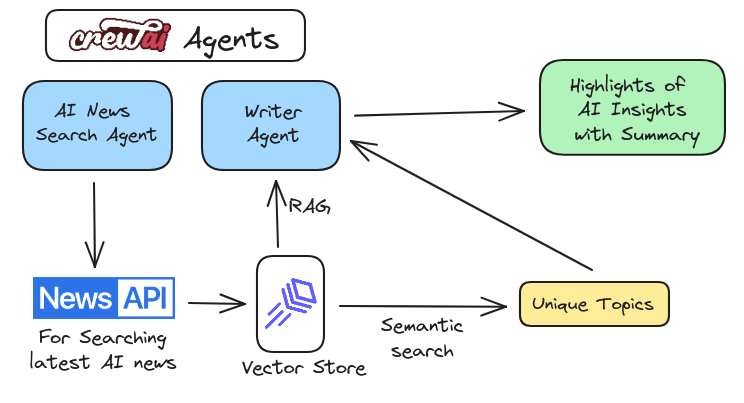

Get Free News API Key at [link](https://newsapi.org/)

### Install required packages


In [17]:
!pip install crewai langchain-community langchain-openai requests duckduckgo-search lancedb -q

### Importing modules

In [18]:
from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from langchain_core.retrievers import BaseRetriever
from langchain_openai import OpenAIEmbeddings
from langchain.tools import tool
from langchain_community.document_loaders import WebBaseLoader
import requests, os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import LanceDB
from langchain_community.tools import DuckDuckGoSearchRun

### Set API keys as environment variable

In [19]:
os.environ["NEWSAPI_KEY"] = "*********"
os.environ["OPENAI_API_KEY"] = "sk-*********"

### Using OpenAI embedding function and LLM

In [20]:
embedding_function = OpenAIEmbeddings()
llm = ChatOpenAI(model="gpt-4-turbo-preview")

### Set up the LanceDB vectorDB

In [58]:
import lancedb


# creating lancedb table with dummy data
def lanceDBConnection(dataset):
    db = lancedb.connect("/tmp/lancedb")
    table = db.create_table("tb", data=dataset, mode="overwrite")
    return table


embedding = OpenAIEmbeddings()
emb = embedding.embed_query("hello_world")
dataset = [{"vector": emb, "text": "dummy_text"}]

# LanceDB as vector store
table = lanceDBConnection(dataset)

### Save latest AI News in vectorDB

In [59]:
# Save the news articles in a database
class SearchNewsDB:
    @tool("News DB Tool")
    def news(query: str):
        """Fetch news articles and process their contents."""
        API_KEY = os.getenv("NEWSAPI_KEY")  # Fetch API key from environment variable
        base_url = f"https://newsapi.org/v2/top-headlines?sources=techcrunch"

        params = {
            "sortBy": "publishedAt",
            "apiKey": API_KEY,
            "language": "en",
            "pageSize": 15,
        }

        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            return "Failed to retrieve news."

        articles = response.json().get("articles", [])
        all_splits = []
        for article in articles:
            # Assuming WebBaseLoader can handle a list of URLs
            loader = WebBaseLoader(article["url"])
            docs = loader.load()

            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000, chunk_overlap=200
            )
            splits = text_splitter.split_documents(docs)
            all_splits.extend(splits)  # Accumulate splits from all articles

        # Index the accumulated content splits if there are any
        if all_splits:
            vectorstore = LanceDB.from_documents(
                all_splits, embedding=embedding_function, connection=table
            )
            retriever = vectorstore.similarity_search(query)
            return retriever
        else:
            return "No content available for processing."

### Building RAG to get news from vectorDB

In [60]:
# Get the news articles from the database
class GetNews:
    @tool("Get News Tool")
    def news(query: str) -> str:
        """Search LanceDB for relevant news information based on a query."""
        vectorstore = LanceDB(embedding=embedding_function, connection=table)
        retriever = vectorstore.similarity_search(query)
        return retriever

### Setup search tool for News articles on the web

In [34]:
# Make sure to Install duckduckgo-search for this example
# !pip install -U duckduckgo-search

search_tool = DuckDuckGoSearchRun()

### Setting up Agents

In [63]:
# Defining Search and Writer agents with roles and goals
news_search_agent = Agent(
    role="AI News Searcher",
    goal="Generate key points for each news article from the latest news",
    backstory="""You work at a leading tech think tank.
  Your expertise lies in identifying emerging trends in field of AI.
  You have a knack for dissecting complex data and presenting
  actionable insights.""",
    tools=[SearchNewsDB().news],
    allow_delegation=True,
    verbose=True,
    llm=llm,
)

writer_agent = Agent(
    role="Writer",
    goal="Identify all the topics received. Use the Get News Tool to verify the each topic to search. Use the Search tool for detailed exploration of each topic. Summarise the retrieved information in depth for every topic.",
    backstory="""You are a renowned Content Strategist, known for
  your insightful and engaging articles.
  You transform complex concepts into compelling narratives.""",
    tools=[GetNews().news, search_tool],
    allow_delegation=True,
    verbose=True,
    llm=llm,
)

### Tasks to perform

In [64]:
# Creating search and writer tasks for agents
news_search_task = Task(
    description="""Conduct a comprehensive analysis of the latest advancements in AI in 2024.
  Identify key trends, breakthrough technologies, and potential industry impacts.
  Your final answer MUST be a full analysis report""",
    expected_output="Create key points list for each news",
    agent=news_search_agent,
    tools=[SearchNewsDB().news],
)

writer_task = Task(
    description="""Using the insights provided, summaries each post of them
  highlights the most significant AI advancements.
  Your post should be informative yet accessible, catering to a tech-savvy audience.
  Make it sound cool, avoid complex words so it doesn't sound like AI.
  Your final answer MUST not be the more than 50 words.""",
    expected_output="Write a short summary under 50 words for each news Headline seperately",
    agent=writer_agent,
    context=[news_search_task],
    tools=[GetNews().news, search_tool],
)

### Create a Crew

In [65]:
# Instantiate Crew with Agents and their tasks
news_crew = Crew(
    agents=[news_search_agent, writer_agent],
    tasks=[news_search_task, writer_task],
    process=Process.sequential,
    manager_llm=llm,
)

In [66]:
news_crew

Crew(id=f00c1b10-95c4-4ce4-bbf0-ce2d4d6b1e1b, process=sequential, number_of_agents=2, number_of_tasks=2)

### Kickoff the crew - let the magic happen

In [67]:
# Execute the crew to see RAG in action
result = news_crew.kickoff()



> Entering new CrewAgentExecutor chain...
To begin the task of conducting a comprehensive analysis of the latest advancements in AI in 2024, I first need to gather recent news articles related to AI advancements. This will help identify key trends, breakthrough technologies, and their potential impacts on various industries. Given the tools at my disposal, I will use the News DB Tool to fetch recent news articles on AI advancements.

Action: News DB Tool
Action Input: {"query": "latest advancements in AI 2024"} 

[Document(page_content='A quiet winner\nWhile the song and dance surrounding Astera Labs’ public offering has been noticeably quieter than that surrounding Reddit’s IPO, there’s reason to believe that it is more a test of the market’s demand for AI shares than Reddit’s own debut; while Reddit’s AI-based data business is certainly a growing portion of its operations, it remains a single-digit percentage of its anticipated 2023 per TechCrunch analysis.\nIn contrast, the AI-led

In [68]:
print(result)

1. Astera Labs' IPO reveals a booming AI market, focusing on data center AI tech, showing diverse AI industry growth.
2. A new deep tech fund bets big on AI, targeting sectors from energy to biotech, indicating high investor confidence.
3. NATO's €1 billion fund invests in AI startups, emphasizing AI's strategic global importance.
4. These developments highlight AI's expanding role in economic and technological innovation across various sectors.
